# Multiome (scRNA-seq + scATAC-seq data) 

We show an example of scRNA-seq data produced by 10X Chromium. 
We are using scATAC-seq data `PBMC from a Healthy Donor - No Cell Sorting (3k)` (3,009 cells and 117,757 features) from [10X Genomics Datasets](https://www.10xgenomics.com/resources/datasets). The test data is directly available from `Peak by cell matrix HDF5 (filtered)` in [here](https://www.10xgenomics.com/resources/datasets/pbmc-from-a-healthy-donor-no-cell-sorting-3-k-1-standard-2-0-0) (registration required).

We use [scanpy](https://scanpy.readthedocs.io/en/stable/) to read/write 10X data. Import numpy and scanpy in addlition to screcode.

In [15]:
import screcode
import numpy as np
import scanpy as sc
import warnings
warnings.simplefilter('ignore')

Read in the count matrix into an [AnnData](https://anndata.readthedocs.io/en/latest/) object. 

In [16]:
input_filename = 'data/pbmc_unsorted_3k_filtered_feature_bc_matrix.h5'
adata = sc.read_10x_h5(input_filename,gex_only=False)
adata.var_names_make_unique()
adata.layers["Raw"] = adata.X.toarray()
adata

AnnData object with n_obs × n_vars = 3009 × 117757
    var: 'gene_ids', 'feature_types', 'genome', 'interval'
    layers: 'Raw'

In [17]:
np.unique(adata.var['feature_types'].values,return_counts=True)

(array(['Gene Expression', 'Peaks'], dtype=object), array([36601, 81156]))

## Apply RECODE
Apply RECODE to the count matrix. **Only anndata data format is available for multiome data**. 

In [18]:
recode = screcode.RECODE(seq_target='Multiome')
adata = recode.fit_transform(adata)

start RECODE for Multiome data
end RECODE for scMultiome-seq
log: {'seq_target': 'Multiome', '#significant features': 87901, '#non-significant features': 19119, '#silent features': 10737, 'ell': 102, 'Elapsed time': '0h 1m 21s 362ms', 'solver': 'full'}


With anndata format, outputs of RECODE are included in anndata objects:
- denoised matrix -> adata.obsm['RECODE']
- noise variance -> adata.var['noise_variance_RECODE']
- normalized variance (NVSN variance) ->  adata.var['normalized_variance_RECODE']
- clasification of genes (significant/non-significant/silent) ->  adata.var['significance_RECODE']

In [19]:
adata

AnnData object with n_obs × n_vars = 3009 × 117757
    var: 'gene_ids', 'feature_types', 'genome', 'interval', 'noise_variance', 'normalized_variance', 'significance_RECODE'
    uns: 'RECODE_essential'
    layers: 'Raw', 'RECODE', 'RECODE_NVSN'

## Performance verification
Show report:

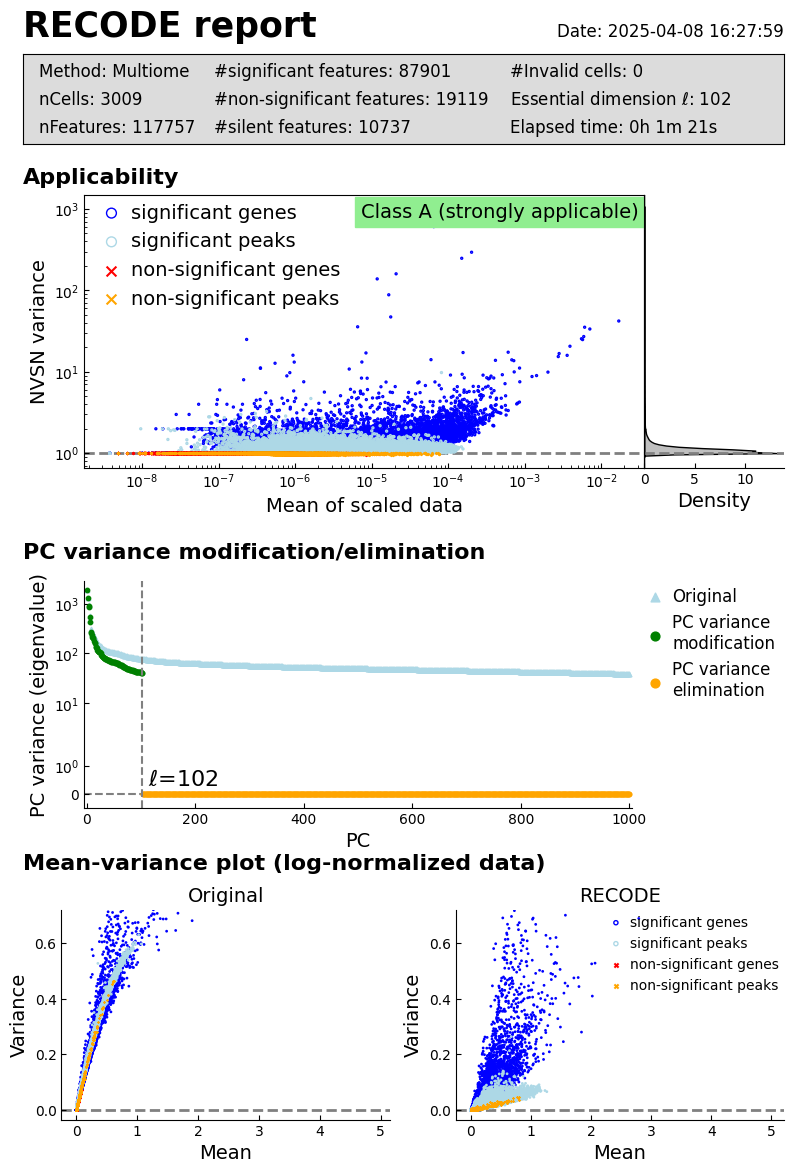

In [20]:
recode.report()

In [21]:
target_sum = 1e6
adata.X = adata.layers["RECODE"]
adata = recode.lognormalize(adata,target_sum=target_sum)
sc.pp.normalize_total(adata, target_sum=target_sum)
sc.pp.log1p(adata)

Normalized data are stored in "RECODE_norm" and "RECODE_log"


In [22]:
adata.layers["Raw_log"] = np.log(target_sum*adata.layers["Raw"]/np.sum(adata.layers["Raw"],axis=1)[:,np.newaxis]+1)

In [23]:
import sklearn.decomposition
n_pcs = 50
adata.obsm["X_pca"] = sklearn.decomposition.PCA(n_components=n_pcs).fit_transform(adata.layers["RECODE_log"])

In [24]:
sc.tl.pca(adata, svd_solver='arpack')

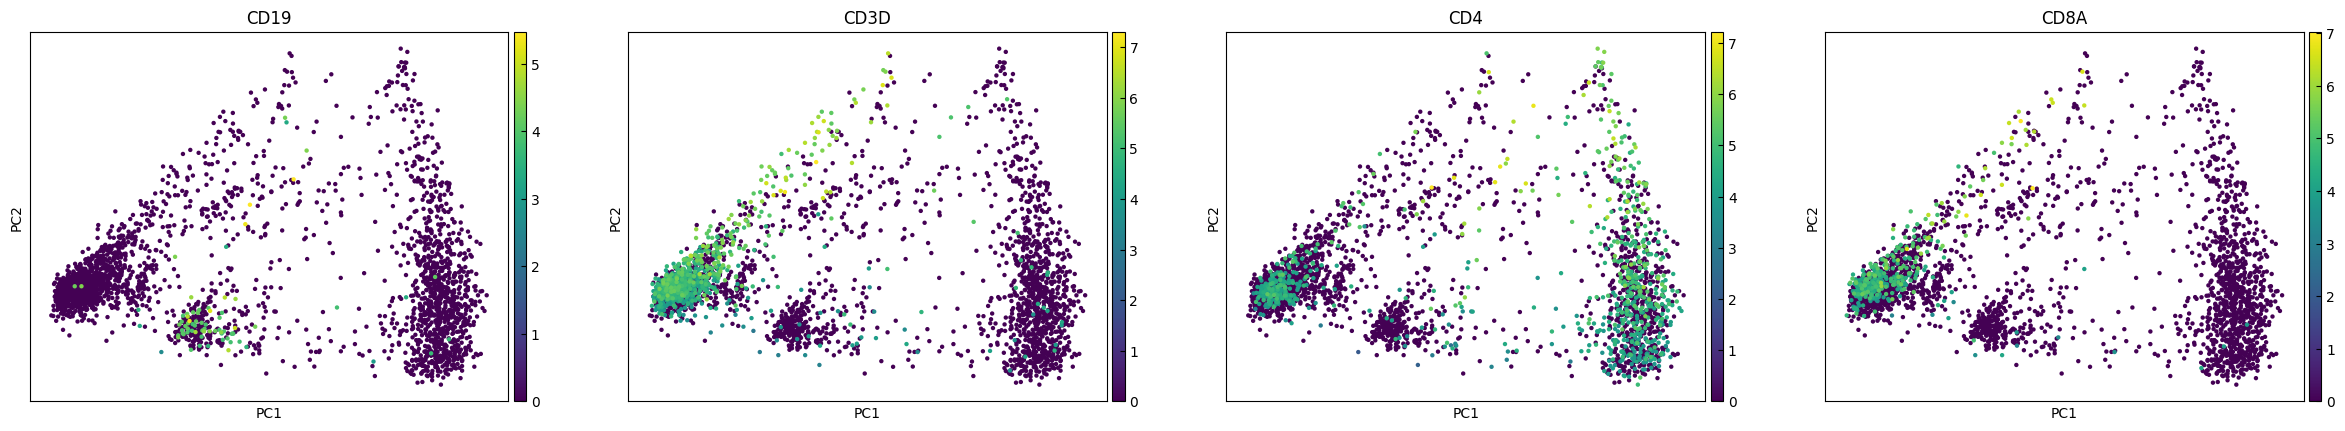

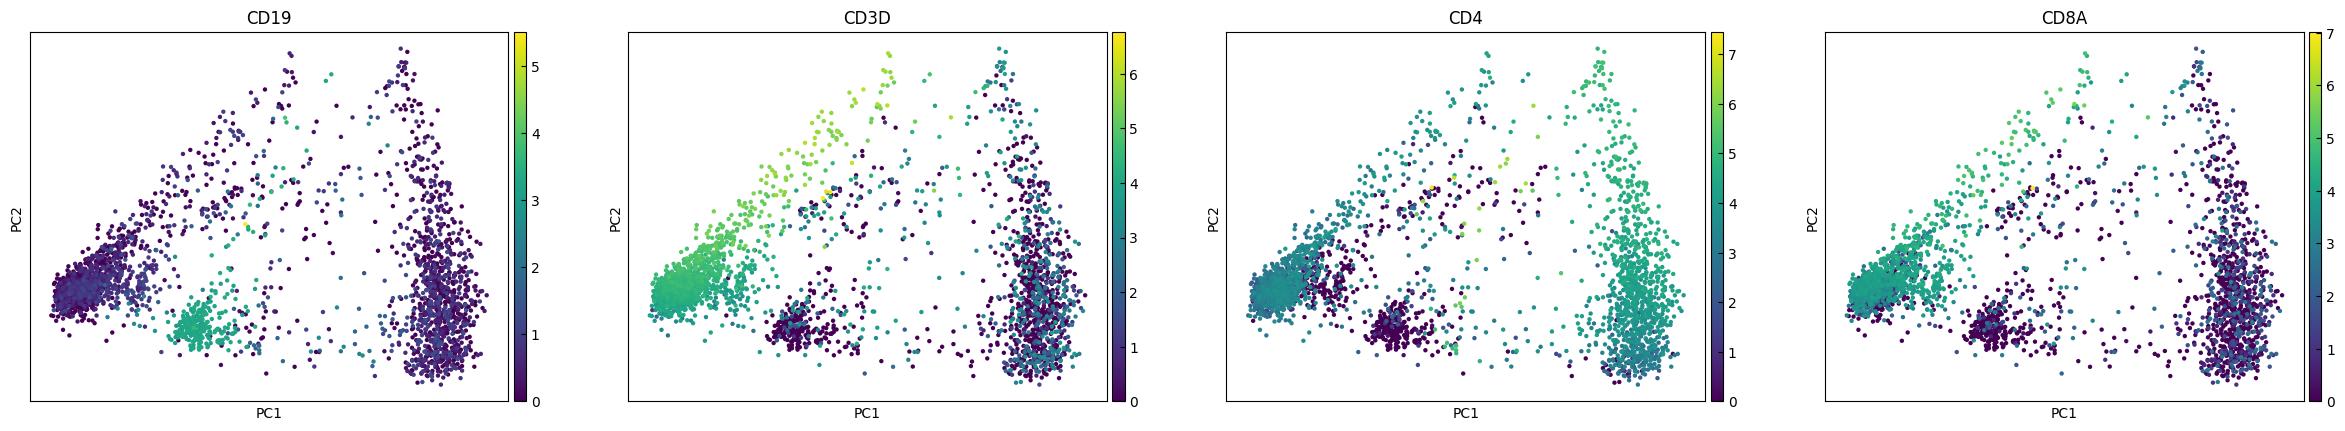

In [25]:
plot_genes = ['CD19','CD3D','CD4','CD8A']
sc.pl.pca(adata, color=plot_genes,layer="Raw_log")
sc.pl.pca(adata, color=plot_genes,layer="RECODE_log")

In [26]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=0)
sc.tl.umap(adata)

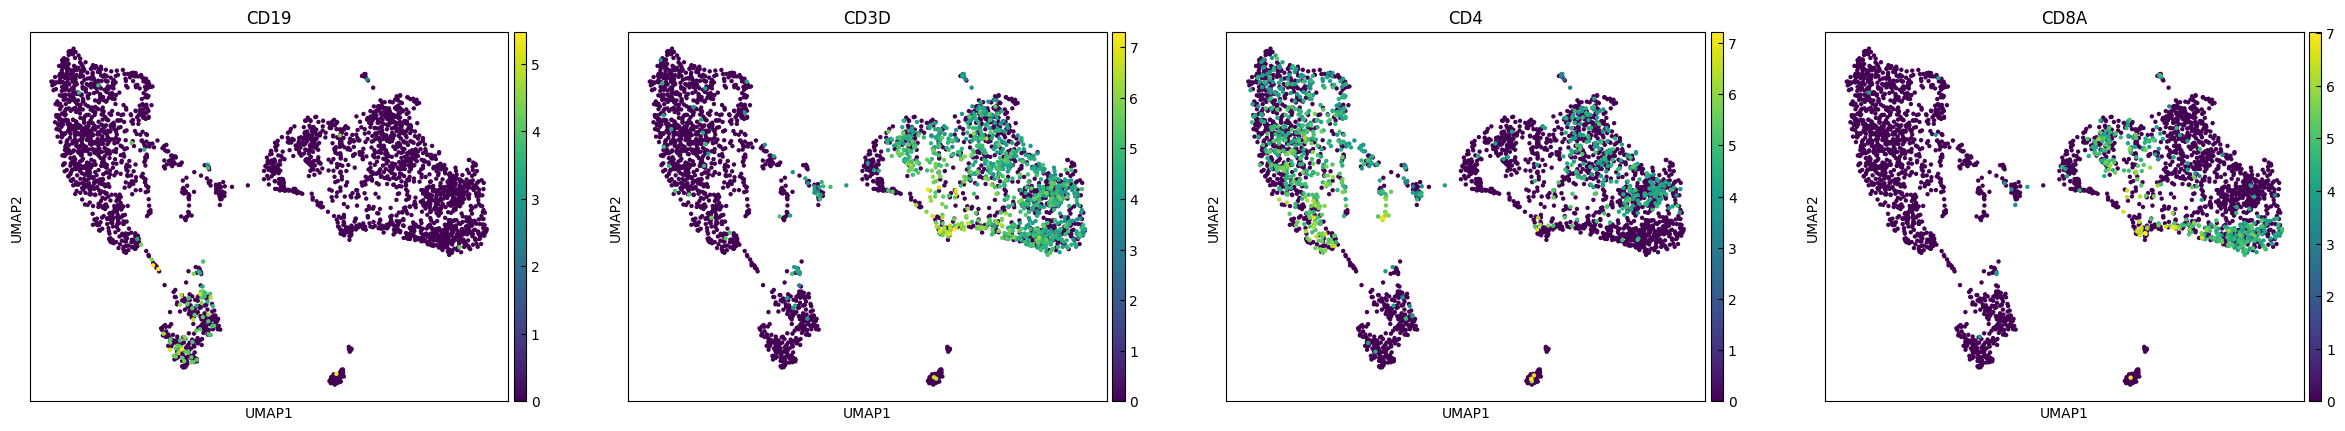

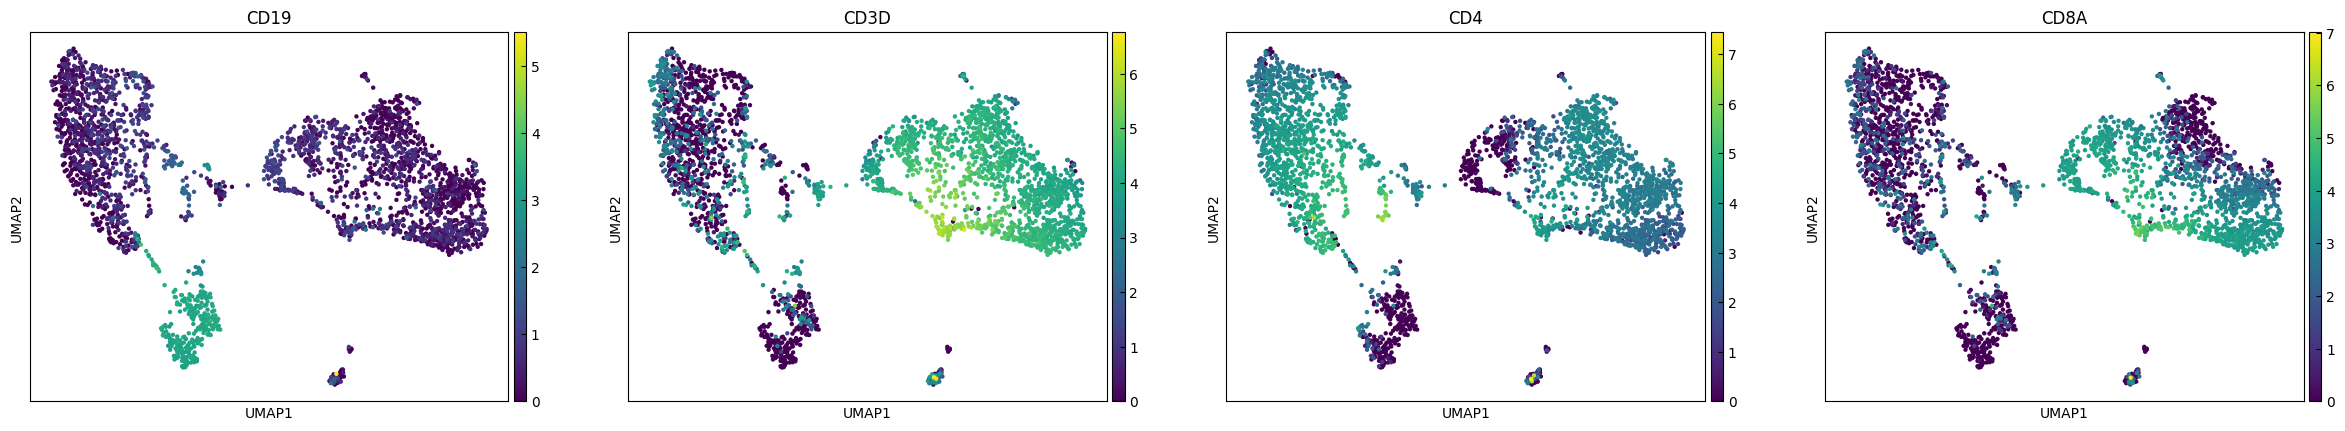

In [27]:
sc.pl.umap(adata, color=plot_genes,layer="Raw_log")
sc.pl.umap(adata, color=plot_genes,layer="RECODE_log")

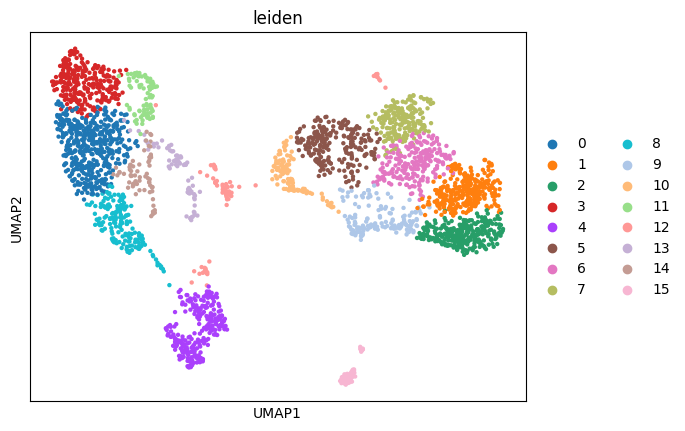

In [28]:
sc.tl.leiden(adata,resolution=1)
sc.pl.umap(adata, color=['leiden'])